In [1]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import torch.nn as nn
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
import numpy as np
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# class OxfordIIITPetDataset(Dataset):
#     @staticmethod
#     def extract_breed(name):
#         return ' '.join(name.split("_")[:-1]).lower().title()

#     def __init__(self, img_dir, transform=None, transform_label=None, label_percentage=1, test_percentage=0.2, only_indexes=None, unlabeled=False):
#         self.img_dir = img_dir
#         self.image_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]
#         self.indexes = only_indexes
#         if self.indexes is None:
#             n = len(self.image_names)
#             self.indexes = list(range(n))
#             np.random.shuffle(self.indexes)
#             test_i = math.ceil(test_percentage * n)
#             self.test_indexes = self.indexes[:test_i]
#             self.indexes = self.indexes[test_i:]
#             n = len(self.indexes)
#             label_i = math.ceil(label_percentage * n)
#             self.unlabeled_indexes = self.indexes[label_i:]
#             self.indexes = self.indexes[:label_i]

#         if unlabeled:
#             self.values = [None] * len(self.indexes)
        
#         self.transform = transform
#         self.transform_label = transform_label
#         self.labels = list(set([self.extract_breed(name) for name in self.image_names]))
#         self.labels_to_idx = {item: idx for idx, item in enumerate(self.labels)}

#     def __len__(self):
#         return len(self.indexes)
    
#     def get_label(self, idx):
#         idx = self.indexes[idx]
#         image_name = self.image_names[idx]
#         label = self.extract_breed(image_name)
#         return label
    
#     def __setitem___(self, idx, value):
#         if hasattr(self, 'values'):
#             self.values[idx] = value

#     def __getitem__(self, _idx):
#         idx = self.indexes[_idx]
#         image_name = self.image_names[idx]
#         img_path = os.path.join(self.img_dir, image_name)
#         image = Image.open(img_path).convert('RGB')
#         label = self.extract_breed(image_name)
#         label = self.labels_to_idx[label]
#         if hasattr(self, 'values'):
#             label = self.values[_idx]
        
#         if self.transform:
#             image = self.transform(image)
#         if self.transform_label:
#             label = self.transform_label(label)
#         return image, label, _idx
    
#     def create_unlabeled(self):
#         return self.__class__(self.img_dir, self.transform, only_indexes=self.unlabeled_indexes, unlabeled=True)
    
#     def create_test(self):
#         return self.__class__(self.img_dir, self.transform, only_indexes=self.test_indexes)

In [3]:
class OxfordIIITPetDataset(Dataset):
    @staticmethod
    def extract_breed(name):
        return ' '.join(name.split("_")[:-1]).lower().title()

    def __init__(self, img_dir, transform=None, transform_label=None):
        self.img_dir = img_dir
        self.image_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]
        self.transform = transform
        self.transform_label = transform_label
        self.labels = list(set([self.extract_breed(name) for name in self.image_names]))
        self.labels_to_idx = {item: idx for idx, item in enumerate(self.labels)}
        self.values = {}

    def __len__(self):
        return len(self.image_names)
    
    def set_prediction(self, idx, value):
        self.values[idx] = value

    def get_label(self, idx):
        image_name = self.image_names[idx]
        label = self.extract_breed(image_name)
        return label

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        label = self.extract_breed(image_name)
        label = self.labels_to_idx[label]
        if idx in self.values:
            label = self.values[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label, idx
    
    def random_split_equal_distribution(self, split_ratios):
        assert sum(split_ratios) == 1.0, "Split ratios must sum to 1"

        label_indices = {label: [] for label in self.labels}

        # Group indices by label
        for idx in range(len(self)):
            label = self.get_label(idx)
            label_indices[label].append(idx)

        sub_indices = [[] for _ in range(len(split_ratios))]
        datasets = [None for _ in range(len(split_ratios))]

        # Shuffle indices within each label group and create subsets
        for label, indices in label_indices.items():
            np.random.shuffle(indices)
            num_samples = len(indices)
            start_idx = 0

            for i, ratio in enumerate(split_ratios):
                end_idx = start_idx + int(ratio * num_samples)
                sub_indices[i].extend(indices[start_idx:end_idx])
                start_idx = end_idx
            
        for i in range(len(split_ratios)):    
            datasets[i] = Subset(self, sub_indices[i])


        return datasets

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop((224, 224)), 
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset = OxfordIIITPetDataset(img_dir='./Dataset/images', transform=transform)
label_dataset, unlabel_dataset, test_dataset = dataset.random_split_equal_distribution([0.4, 0.4, 0.2])

In [6]:
def histogram_of_features(dataset, name):
# Initialize an empty dictionary to store the counts of each label
    label_counts = {}

    # Iterate through the dataset to count the occurrences of each label
    for i in range(len(dataset)):
        label = dataset.dataset.get_label(i)
        label = str(label)
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

    # Extract labels and counts from the dictionary
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title('Histogram of Labels in the Dataset %s' % name)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

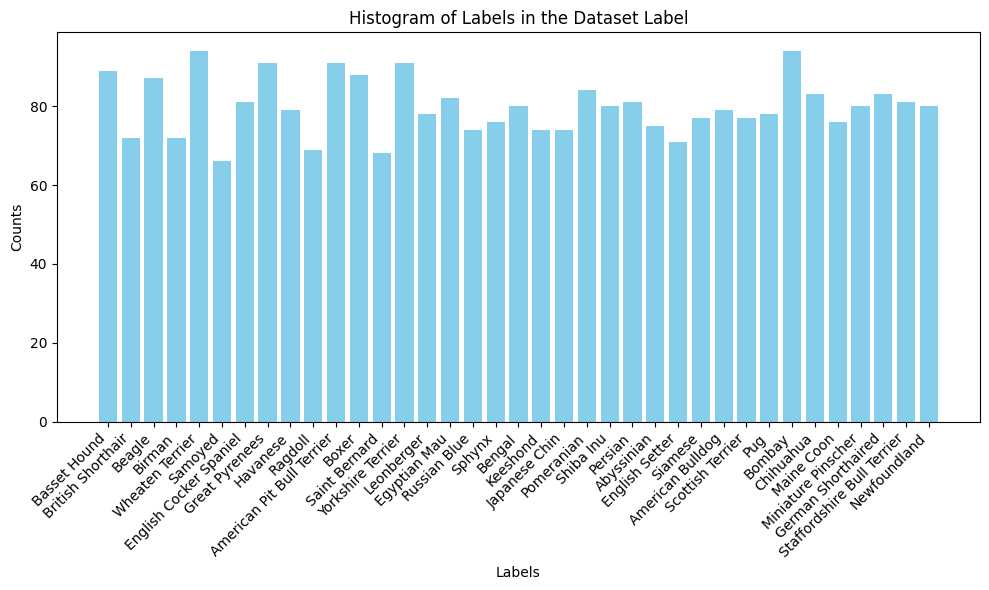

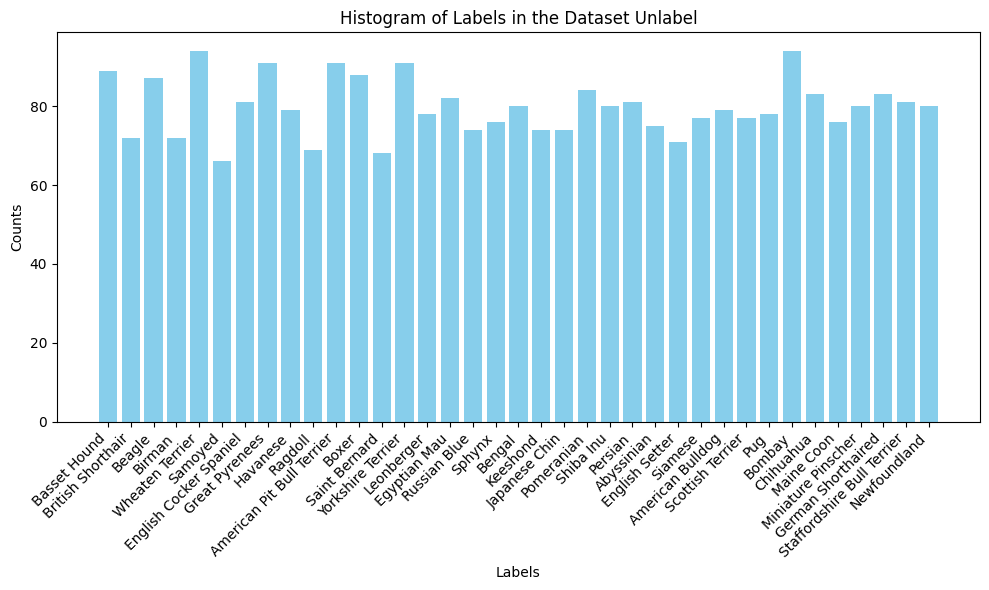

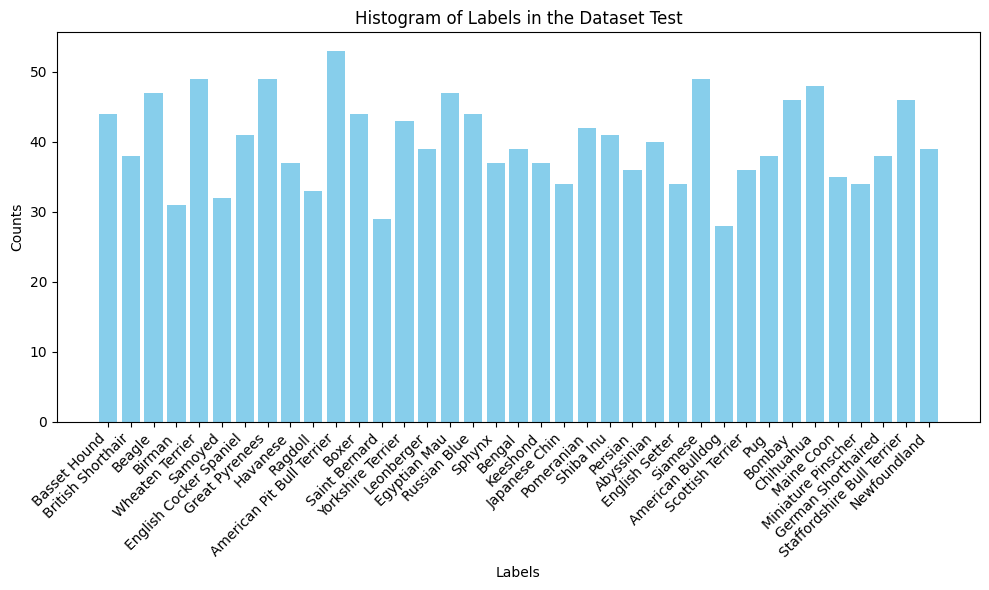

In [7]:
histogram_of_features(label_dataset, 'Label')
histogram_of_features(unlabel_dataset, 'Unlabel')
histogram_of_features(test_dataset, 'Test')

In [8]:
label_dl = DataLoader(label_dataset, batch_size=32, shuffle=True)
unlabel_dl = DataLoader(unlabel_dataset, batch_size=32, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
def build_model(n_features, extra_layers=[], enable_batch_norm=False): # None to get the same as previous, int size of the layer
    pretrained_model = models.resnet18(weights="IMAGENET1K_V1")

    for parameter in pretrained_model.parameters():
        parameter.requires_grad = False

    new_layers = []
    previous = pretrained_model.fc.in_features
    for m in extra_layers:
        if m is None:
            m = previous
        new_layers.append(nn.Linear(previous, m))
        if enable_batch_norm:
            new_layers.append(nn.BatchNorm1d(m))
        new_layers.append(nn.ReLU(inplace=True))
        previous = m

    new_layers.append(nn.Linear(previous, n_features))
    if enable_batch_norm:
        new_layers.append(nn.BatchNorm1d(n_features))


    pretrained_model.fc = nn.Sequential(*new_layers)
    return pretrained_model

In [10]:
def test_accuracy(model: OxfordIIITPetDataset, test_loader: DataLoader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for inputs, labels, _ in test_loader:
            inputs = inputs.to(device)  # Move inputs to device (CPU or GPU)
            labels = labels.to(device)  # Move labels to device (CPU or GPU)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            
            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate accuracy
    accuracy = correct / total
    
    return accuracy

In [11]:
def train_model(model: OxfordIIITPetDataset, train_loader: DataLoader, optimizer, epochs, scheduler=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    learning_rates = []

    loss_func = nn.CrossEntropyLoss()
    for epoch in range(epochs):  # loop over the dataset multiple times
        model.train()

        i = 0

        running_loss = 0.0
        for inputs, labels, _ in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            
            lr = optimizer.param_groups[0]['lr']
            learning_rates.append(lr)

            # print statistics
            running_loss += loss.item()
            i += train_loader.batch_size
            if i % 2000 == 0:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')
    return learning_rates

In [12]:
def predict_unlabeled_data(model: OxfordIIITPetDataset, unlabel_dl):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, idx in unlabel_dl:
            inputs = inputs.to(device)  # Move inputs to device (CPU or GPU)
            labels = labels.to(device)  # Move labels to device (CPU or GPU)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


            for i in range(len(predicted)):
                unlabel_dl.dataset.dataset.set_prediction(idx[i], predicted[i])
    cm = confusion_matrix(all_labels, all_predictions)
    cmd = ConfusionMatrixDisplay(cm, display_labels=unlabel_dl.dataset.dataset.labels)
    fig, ax = plt.subplots(figsize=(20,20))
    cmd.plot(ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.show()


In [13]:
def plot_accuracies(accuracies):
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.grid(True)
    plt.show()

def plot_lr(lr):
    plt.plot(lr, marker='o', linestyle='-')
    plt.xlabel('Updates steps')
    plt.ylabel('Learning rate')
    plt.title('Learning rate over Updates steps')
    plt.grid(True)
    plt.show()

In [14]:
def main(extra_layers, unlabeled_percentage=0, epochs=5, sched=None, enable_batch_norm=False):
    unlabeled_percentage = 0.8 * unlabeled_percentage
    dataset = OxfordIIITPetDataset(img_dir='./Dataset/images', transform=transform)
    label_dataset, unlabel_dataset, test_dataset = dataset.random_split_equal_distribution([0.8 - unlabeled_percentage, unlabeled_percentage, 0.2])
    label_dl = DataLoader(label_dataset, batch_size=64, shuffle=True)
    unlabel_dl = DataLoader(unlabel_dataset, batch_size=64, shuffle=True)
    test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)


    pretrained_model = build_model(n_features=len(label_dl.dataset.dataset.labels), extra_layers=extra_layers, enable_batch_norm=enable_batch_norm)

    optimizer = torch.optim.Adam(pretrained_model.parameters())

    scheduler = None

    if sched == 1:
        step_size = (len(label_dl.dataset) // label_dl.batch_size) // 2
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.9)

    learning_rates1 = train_model(pretrained_model, label_dl, optimizer, epochs=min(epochs, 5), scheduler=scheduler)

    acc = test_accuracy(pretrained_model, test_dl)
    print('Accuracy on test data: %s' % acc)

    predict_unlabeled_data(pretrained_model, unlabel_dl)

    train_dataset = Subset(dataset, indices=label_dataset.indices + unlabel_dataset.indices)
    train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    learning_rates2 = train_model(pretrained_model, train_dl, optimizer, epochs=epochs, scheduler=scheduler)

    acc = test_accuracy(pretrained_model, test_dl)
    print('Accuracy on test data: %s' % acc)

    if sched is not None:
        plot_lr(learning_rates1)
        plot_lr(learning_rates2)

[1,  2001] loss: 0.031
[2,  2001] loss: 0.016
[3,  2001] loss: 0.010
[4,  2001] loss: 0.008
[5,  2001] loss: 0.006
[6,  2001] loss: 0.006
[7,  2001] loss: 0.005
[8,  2001] loss: 0.005
[9,  2001] loss: 0.004
[10,  2001] loss: 0.004
Finished Training
Accuracy on test data: 0.8693297224102912


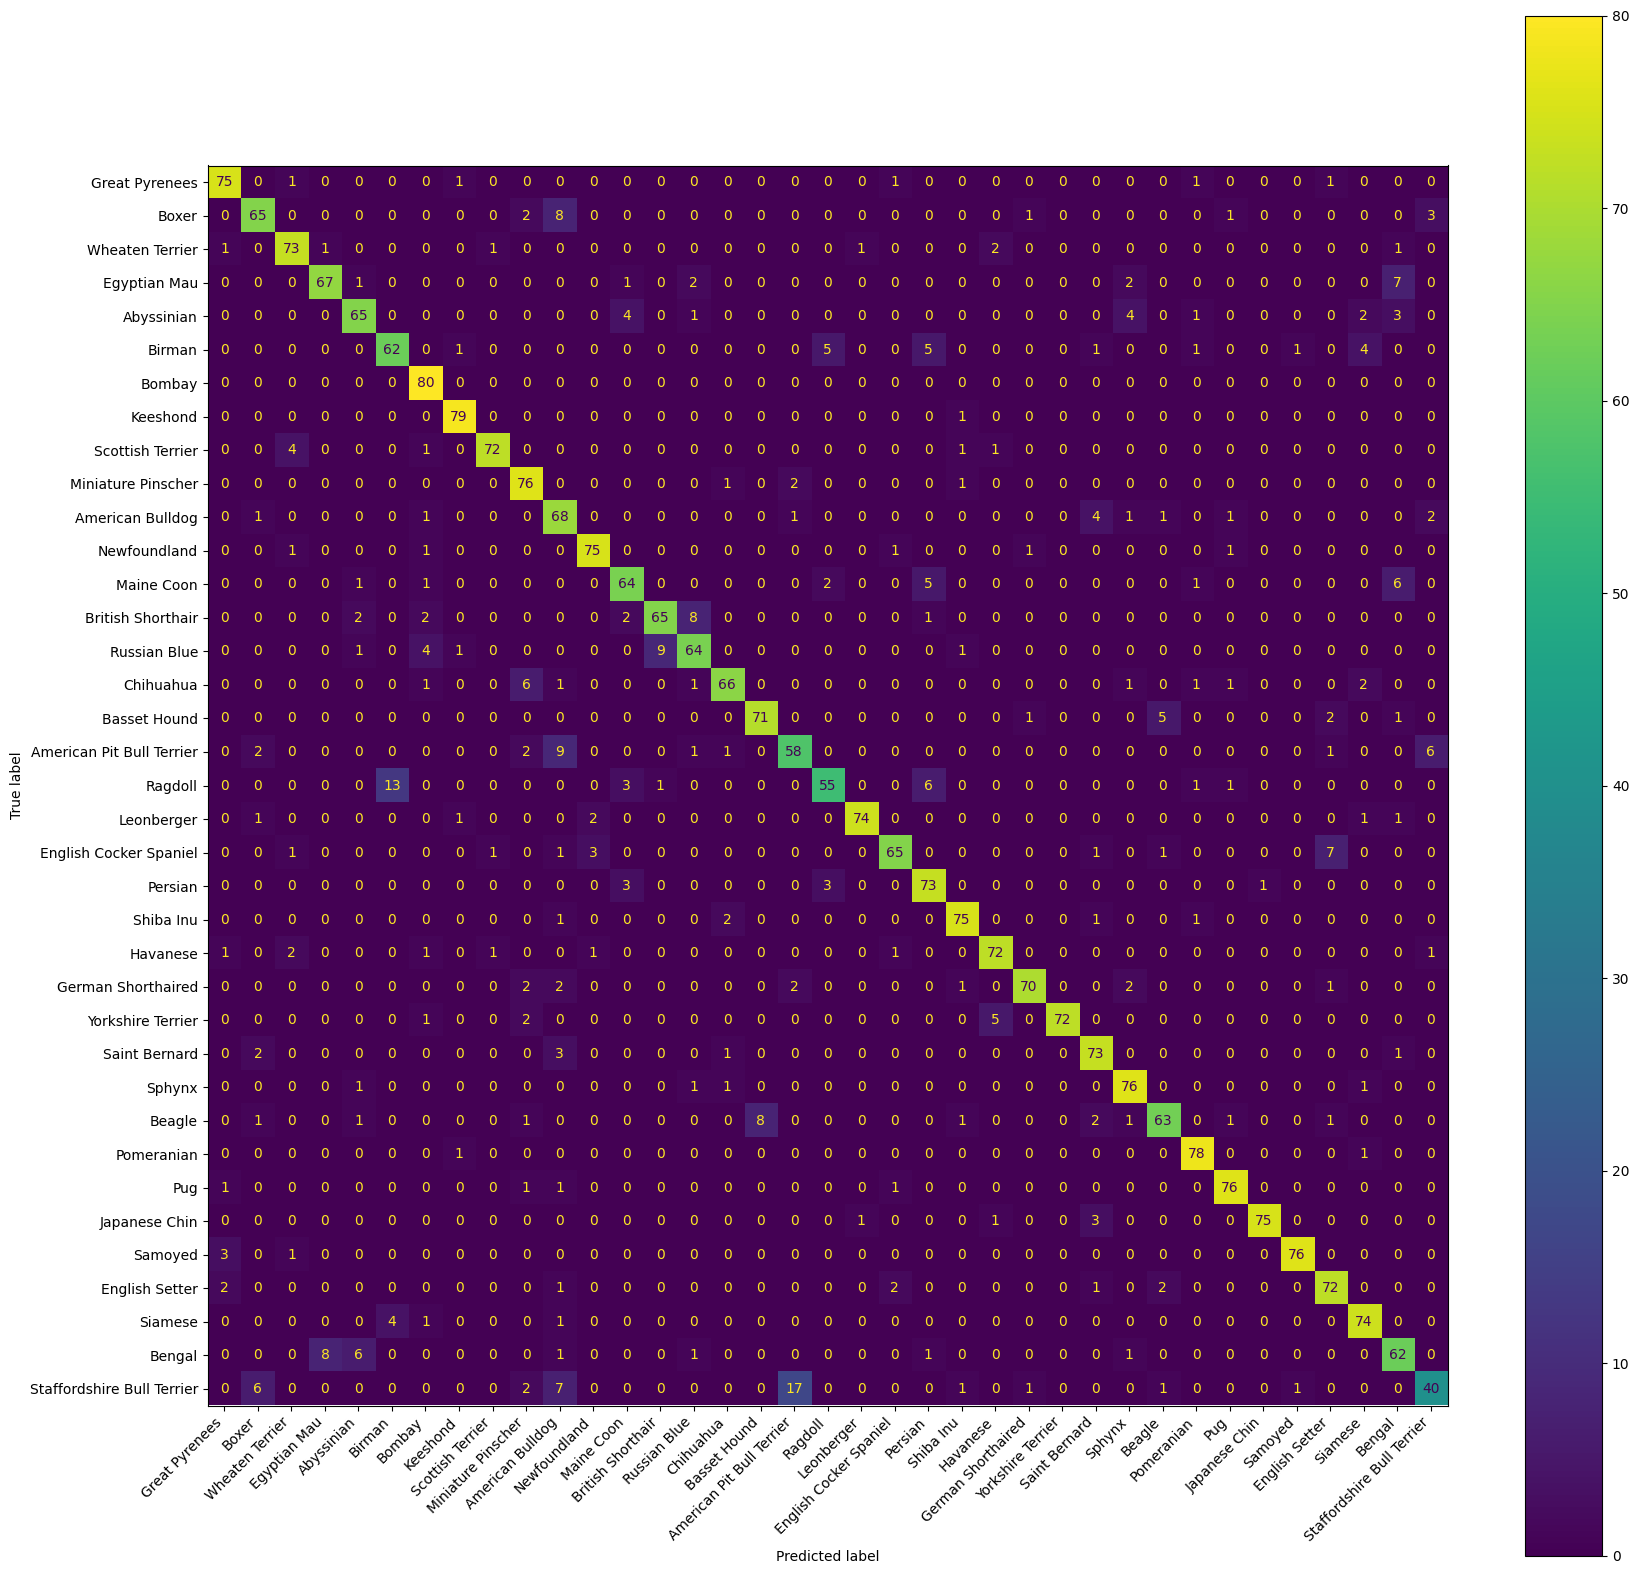

[1,  2001] loss: 0.004
[1,  4001] loss: 0.004
[1,  6001] loss: 0.005
[2,  2001] loss: 0.004
[2,  4001] loss: 0.004
[2,  6001] loss: 0.004
[3,  2001] loss: 0.004
[3,  4001] loss: 0.004
[3,  6001] loss: 0.004
[4,  2001] loss: 0.003
[4,  4001] loss: 0.003
[4,  6001] loss: 0.004
[5,  2001] loss: 0.003
[5,  4001] loss: 0.003
[5,  6001] loss: 0.003
[6,  2001] loss: 0.003
[6,  4001] loss: 0.003
[6,  6001] loss: 0.003
[7,  2001] loss: 0.003
[7,  4001] loss: 0.003
[7,  6001] loss: 0.003
[8,  2001] loss: 0.003
[8,  4001] loss: 0.003
[8,  6001] loss: 0.003
[9,  2001] loss: 0.003
[9,  4001] loss: 0.003
[9,  6001] loss: 0.003
[10,  2001] loss: 0.003
[10,  4001] loss: 0.003
[10,  6001] loss: 0.003
Finished Training
Accuracy on test data: 0.8788083953960731


In [15]:
main(unlabeled_percentage=0.5, extra_layers=[], epochs=10)

Finished Training
Accuracy on test data: 0.8097494922139472


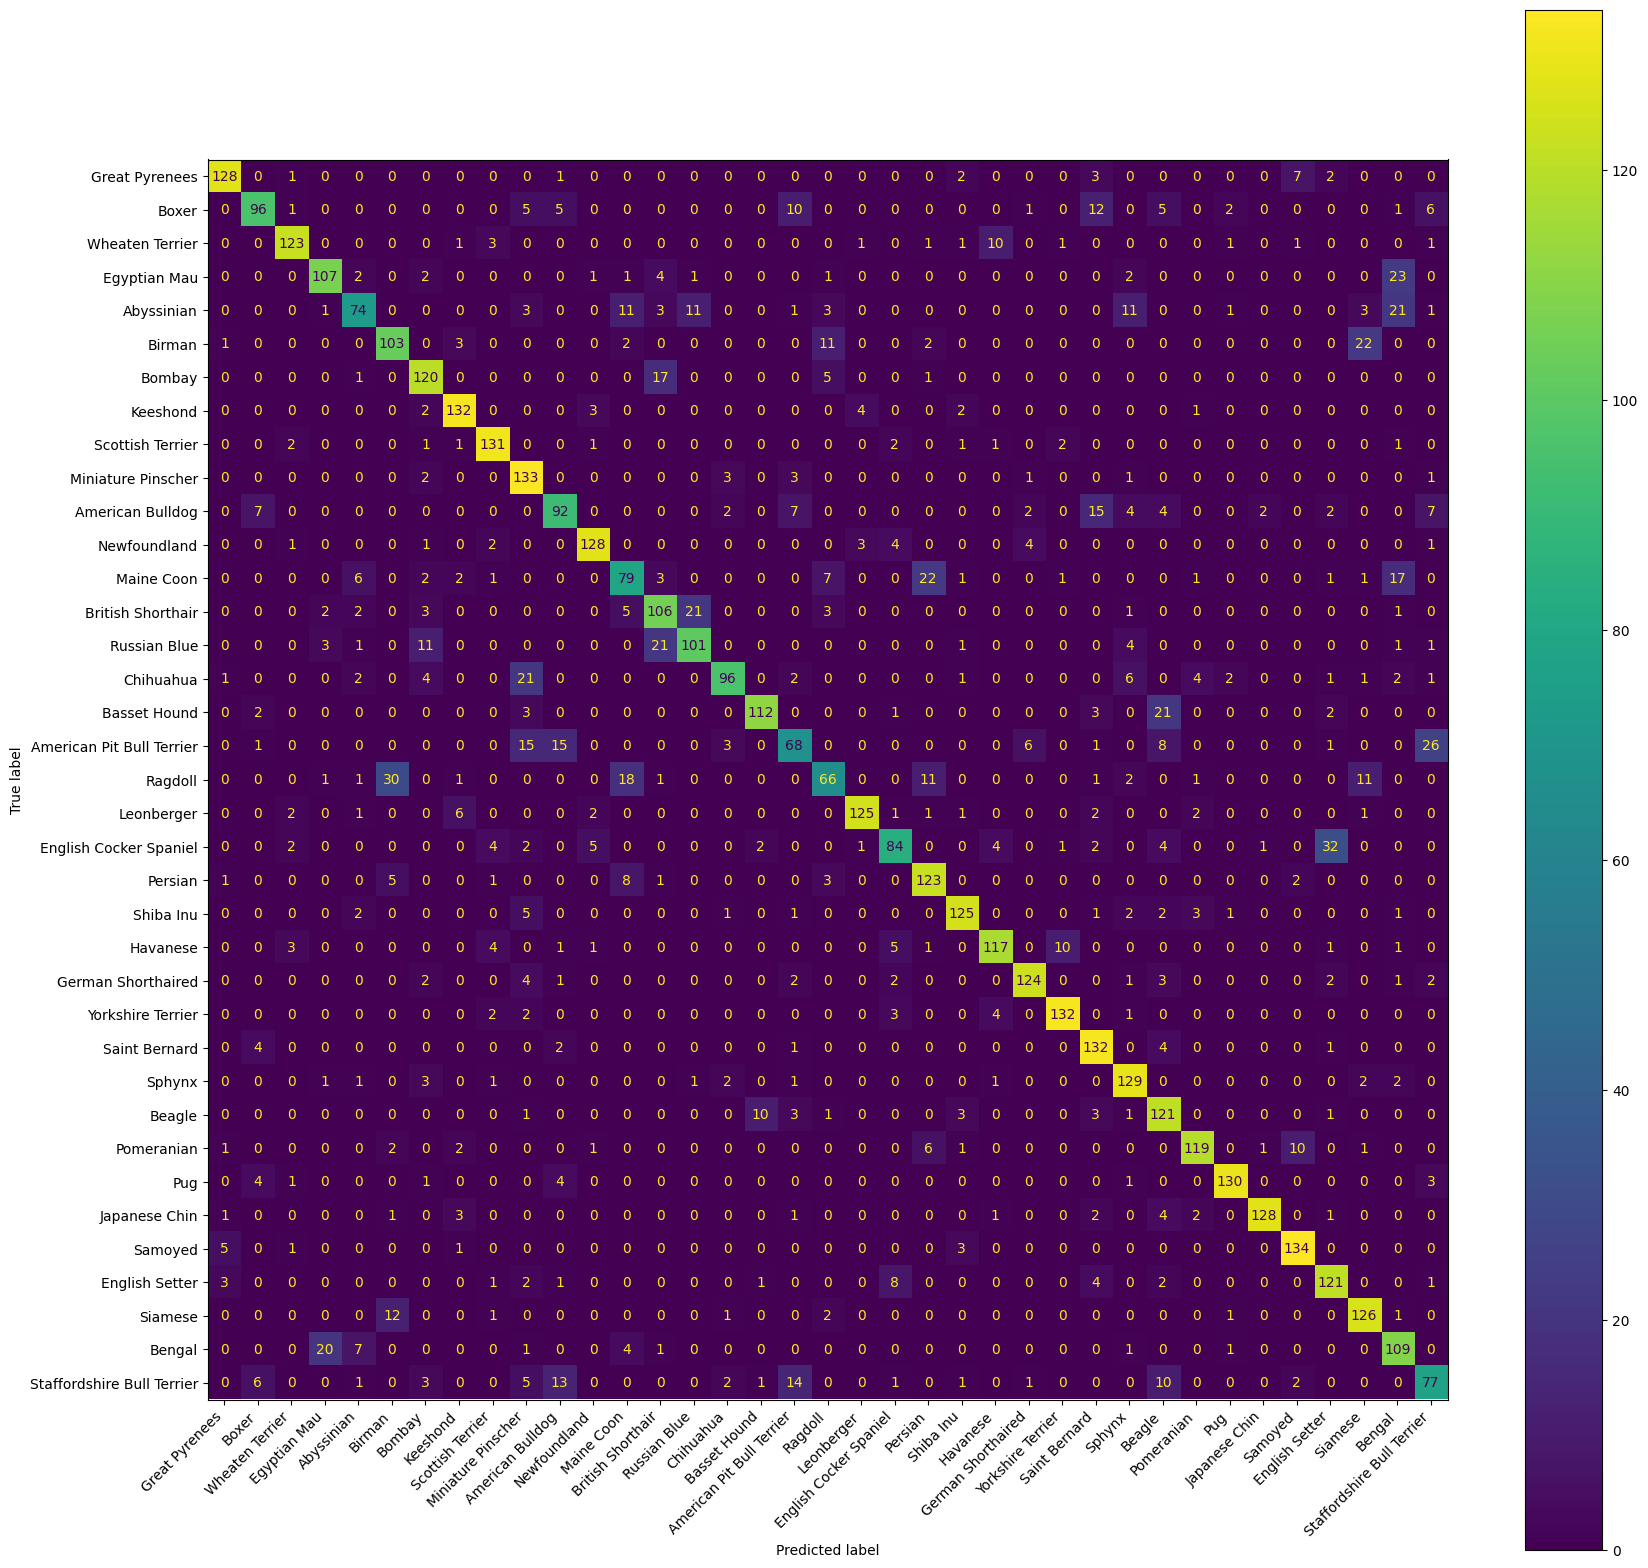

[1,  2001] loss: 0.011
[1,  4001] loss: 0.009
[2,  2001] loss: 0.007
[2,  4001] loss: 0.007
[3,  2001] loss: 0.005
[3,  4001] loss: 0.005
[4,  2001] loss: 0.005
[4,  4001] loss: 0.004
[5,  2001] loss: 0.004
[5,  4001] loss: 0.004
[6,  2001] loss: 0.004
[6,  4001] loss: 0.004
[7,  2001] loss: 0.004
[7,  4001] loss: 0.004
[8,  2001] loss: 0.003
[8,  4001] loss: 0.003
[9,  2001] loss: 0.003
[9,  4001] loss: 0.003
[10,  2001] loss: 0.003
[10,  4001] loss: 0.003
Finished Training
Accuracy on test data: 0.8889641164522681


In [17]:
main(unlabeled_percentage=0.9, extra_layers=[], epochs=10)

Finished Training
Accuracy on test data: 0.27691266079891674


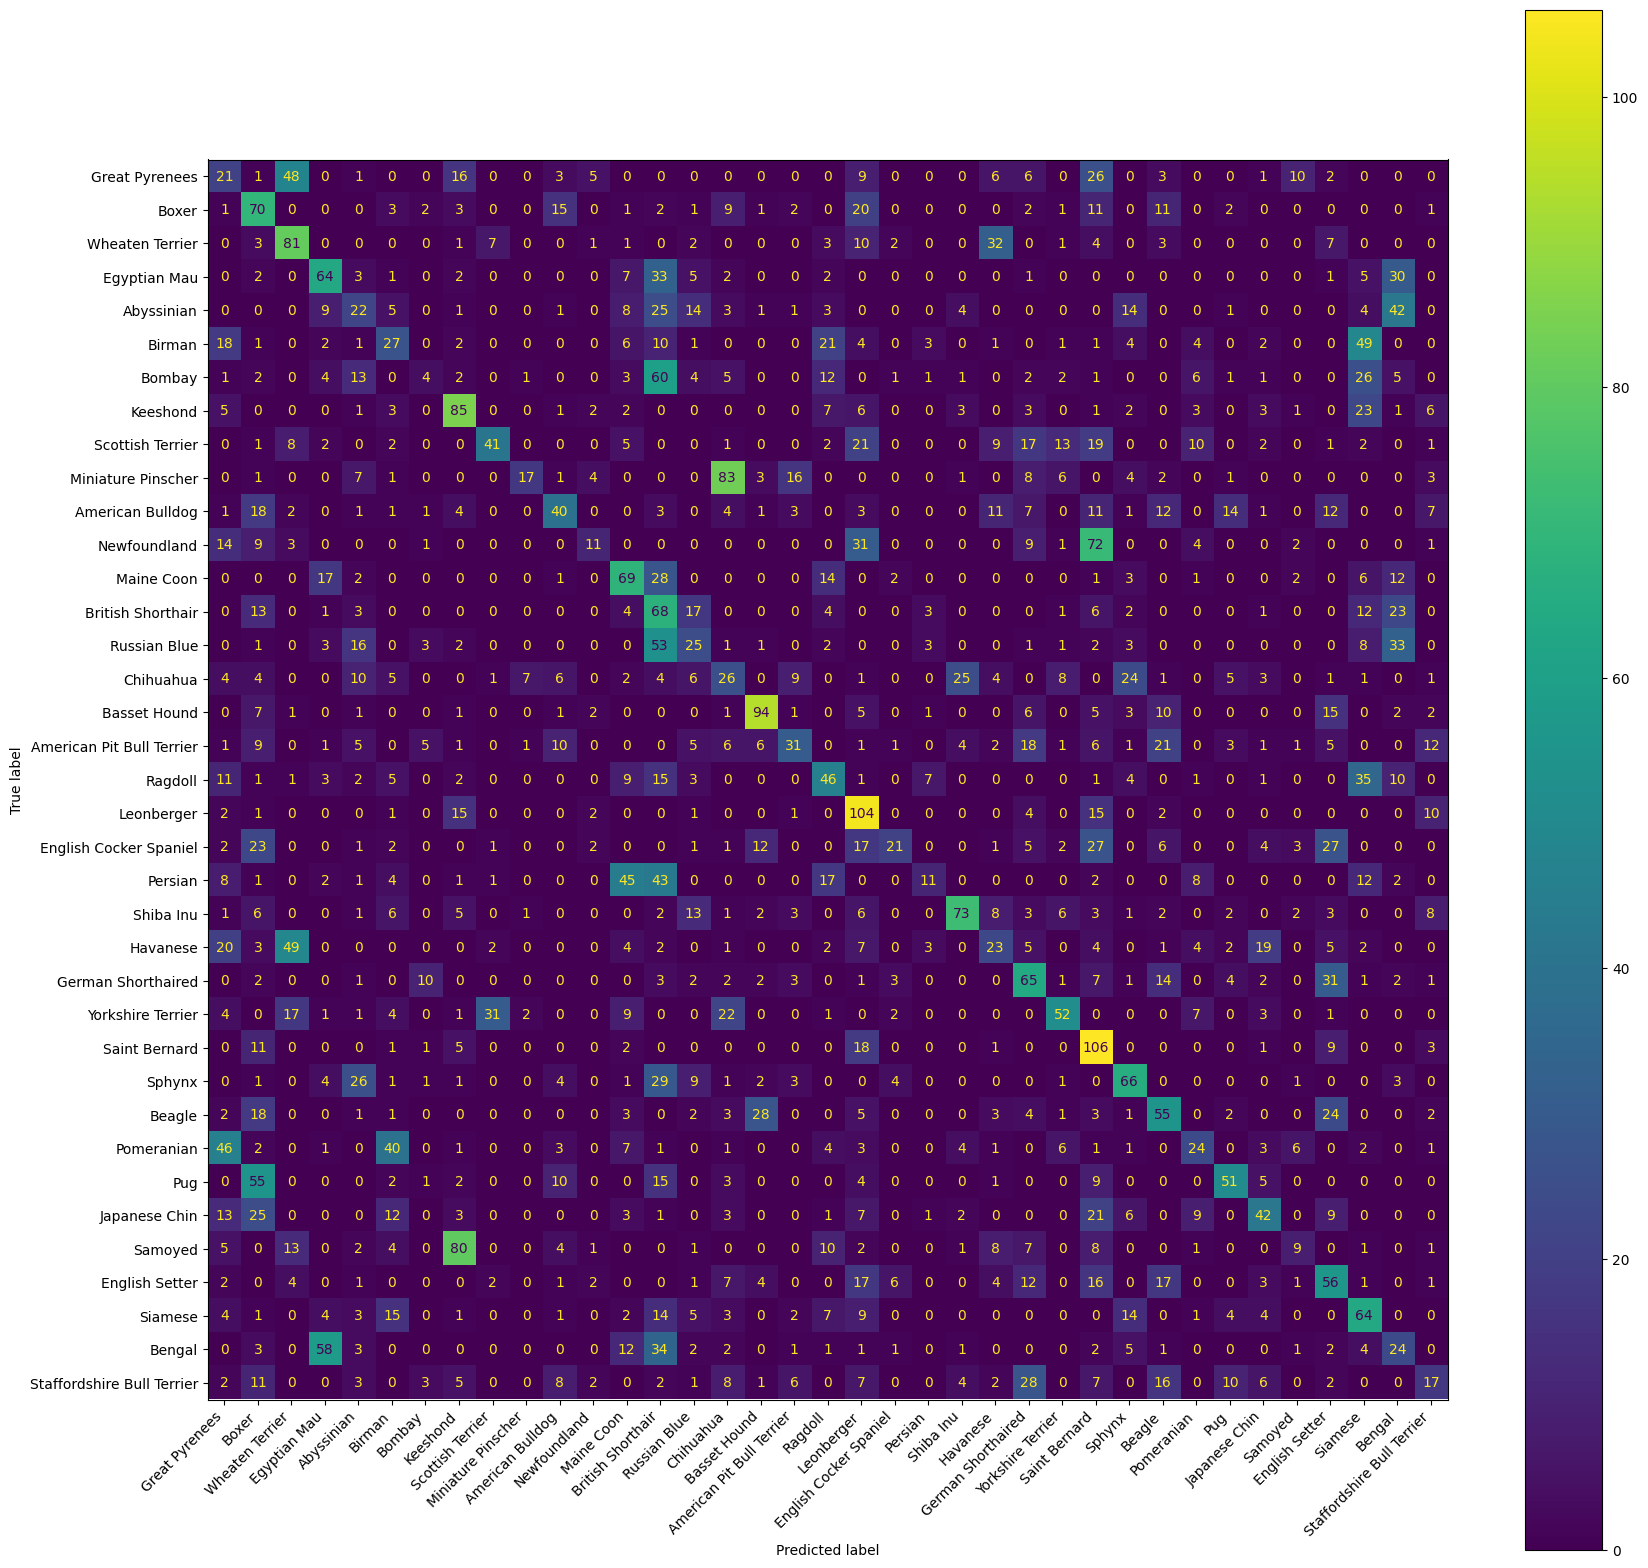

[1,  2001] loss: 0.024
[1,  4001] loss: 0.016
[2,  2001] loss: 0.009
[2,  4001] loss: 0.008
[3,  2001] loss: 0.006
[3,  4001] loss: 0.006
[4,  2001] loss: 0.005
[4,  4001] loss: 0.005
[5,  2001] loss: 0.005
[5,  4001] loss: 0.004
[6,  2001] loss: 0.004
[6,  4001] loss: 0.004
[7,  2001] loss: 0.004
[7,  4001] loss: 0.004
[8,  2001] loss: 0.004
[8,  4001] loss: 0.004
[9,  2001] loss: 0.003
[9,  4001] loss: 0.003
[10,  2001] loss: 0.003
[10,  4001] loss: 0.003
Finished Training
Accuracy on test data: 0.8869329722410291


In [18]:
main(unlabeled_percentage=0.99, extra_layers=[], epochs=10)

## One extra layer

[1,  2001] loss: 0.026
[2,  2001] loss: 0.008
[3,  2001] loss: 0.005
[4,  2001] loss: 0.004
[5,  2001] loss: 0.004
[6,  2001] loss: 0.003
[7,  2001] loss: 0.003
[8,  2001] loss: 0.003
[9,  2001] loss: 0.003
[10,  2001] loss: 0.002
Finished Training
Accuracy on test data: 0.8686526743398781


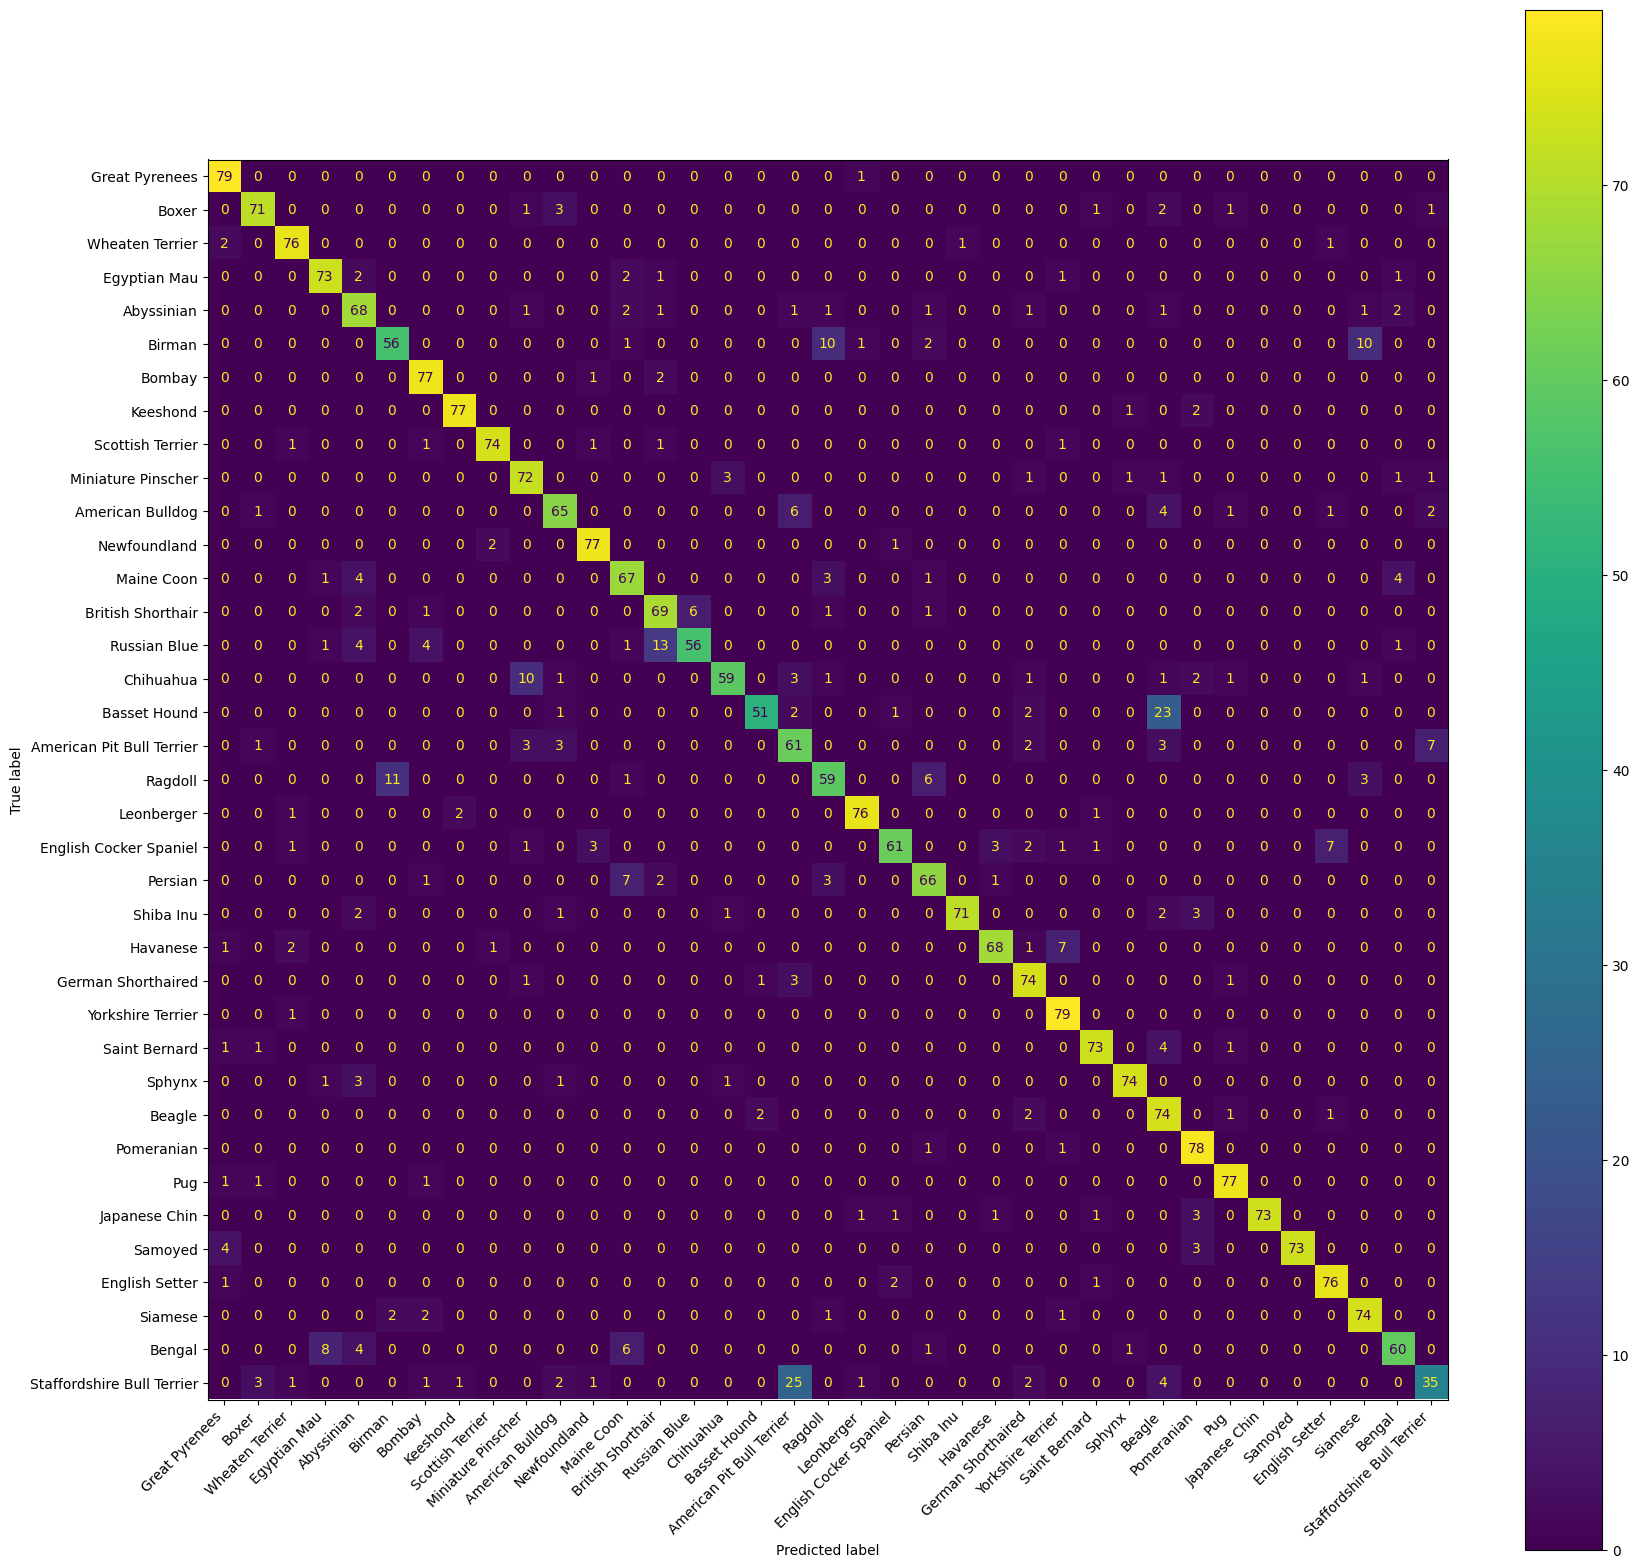

[1,  2001] loss: 0.003
[1,  4001] loss: 0.004
[1,  6001] loss: 0.003
[2,  2001] loss: 0.003
[2,  4001] loss: 0.003
[2,  6001] loss: 0.003
[3,  2001] loss: 0.003
[3,  4001] loss: 0.003
[3,  6001] loss: 0.003
[4,  2001] loss: 0.003
[4,  4001] loss: 0.003
[4,  6001] loss: 0.003
[5,  2001] loss: 0.003
[5,  4001] loss: 0.002
[5,  6001] loss: 0.002
[6,  2001] loss: 0.002
[6,  4001] loss: 0.002
[6,  6001] loss: 0.003
[7,  2001] loss: 0.002
[7,  4001] loss: 0.002
[7,  6001] loss: 0.003
[8,  2001] loss: 0.003
[8,  4001] loss: 0.002
[8,  6001] loss: 0.003
[9,  2001] loss: 0.003
[9,  4001] loss: 0.002
[9,  6001] loss: 0.002
[10,  2001] loss: 0.002
[10,  4001] loss: 0.002
[10,  6001] loss: 0.002
Finished Training
Accuracy on test data: 0.8578199052132701


In [19]:
main(unlabeled_percentage=0.5, extra_layers=[None], epochs=10)

Finished Training
Accuracy on test data: 0.7921462423832092


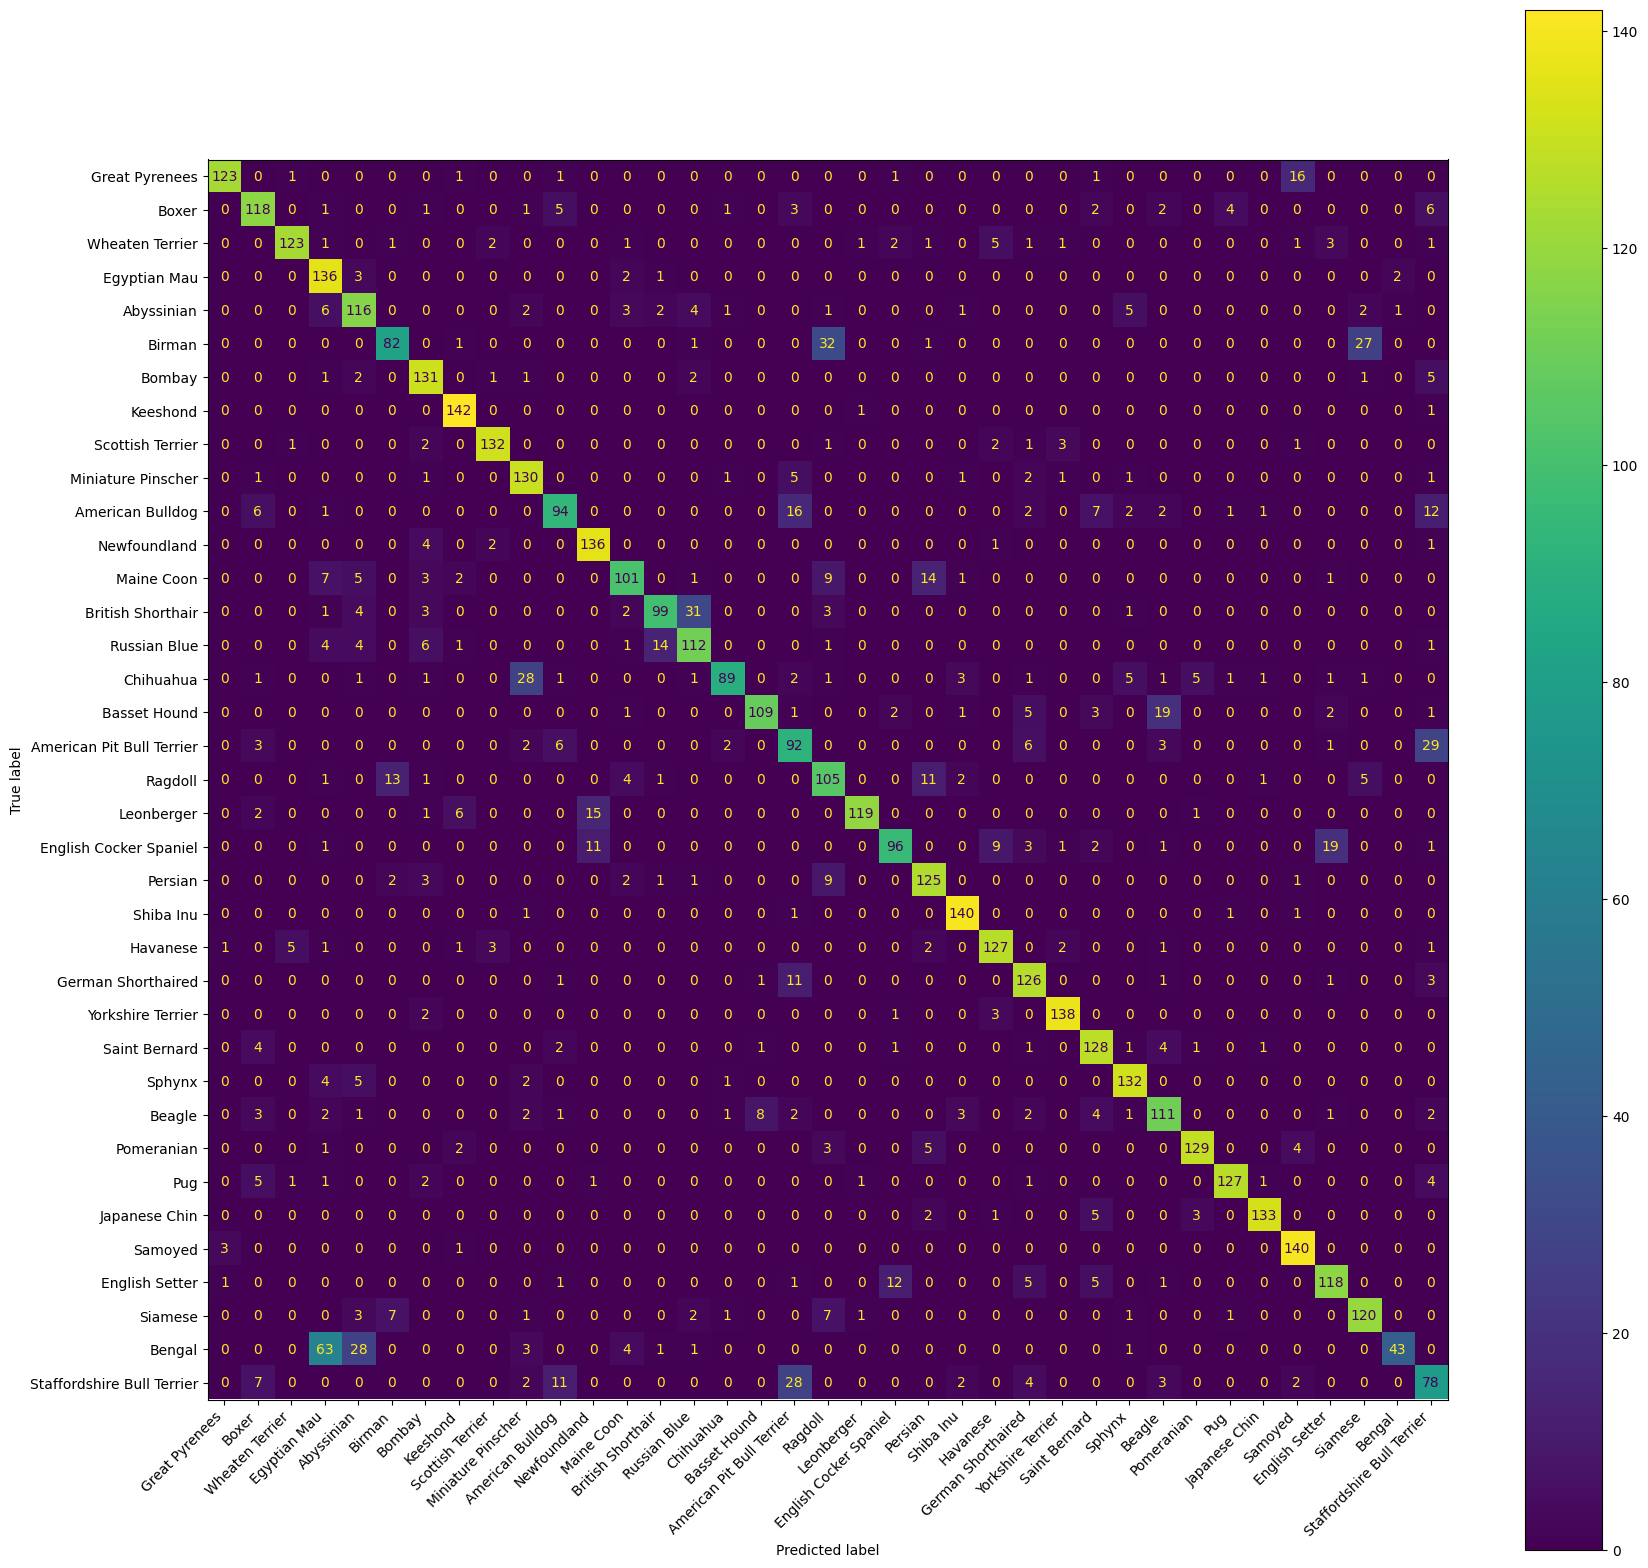

[1,  2001] loss: 0.006
[1,  4001] loss: 0.006
[2,  2001] loss: 0.004
[2,  4001] loss: 0.004
[3,  2001] loss: 0.004
[3,  4001] loss: 0.003
[4,  2001] loss: 0.003
[4,  4001] loss: 0.003
[5,  2001] loss: 0.003
[5,  4001] loss: 0.003
[6,  2001] loss: 0.003
[6,  4001] loss: 0.002
[7,  2001] loss: 0.002
[7,  4001] loss: 0.002
[8,  2001] loss: 0.002
[8,  4001] loss: 0.002
[9,  2001] loss: 0.002
[9,  4001] loss: 0.002
[10,  2001] loss: 0.002
[10,  4001] loss: 0.002
Finished Training
Accuracy on test data: 0.8733920108327691


In [20]:
main(unlabeled_percentage=0.9, extra_layers=[None], epochs=10)

Finished Training
Accuracy on test data: 0.5132024373730535


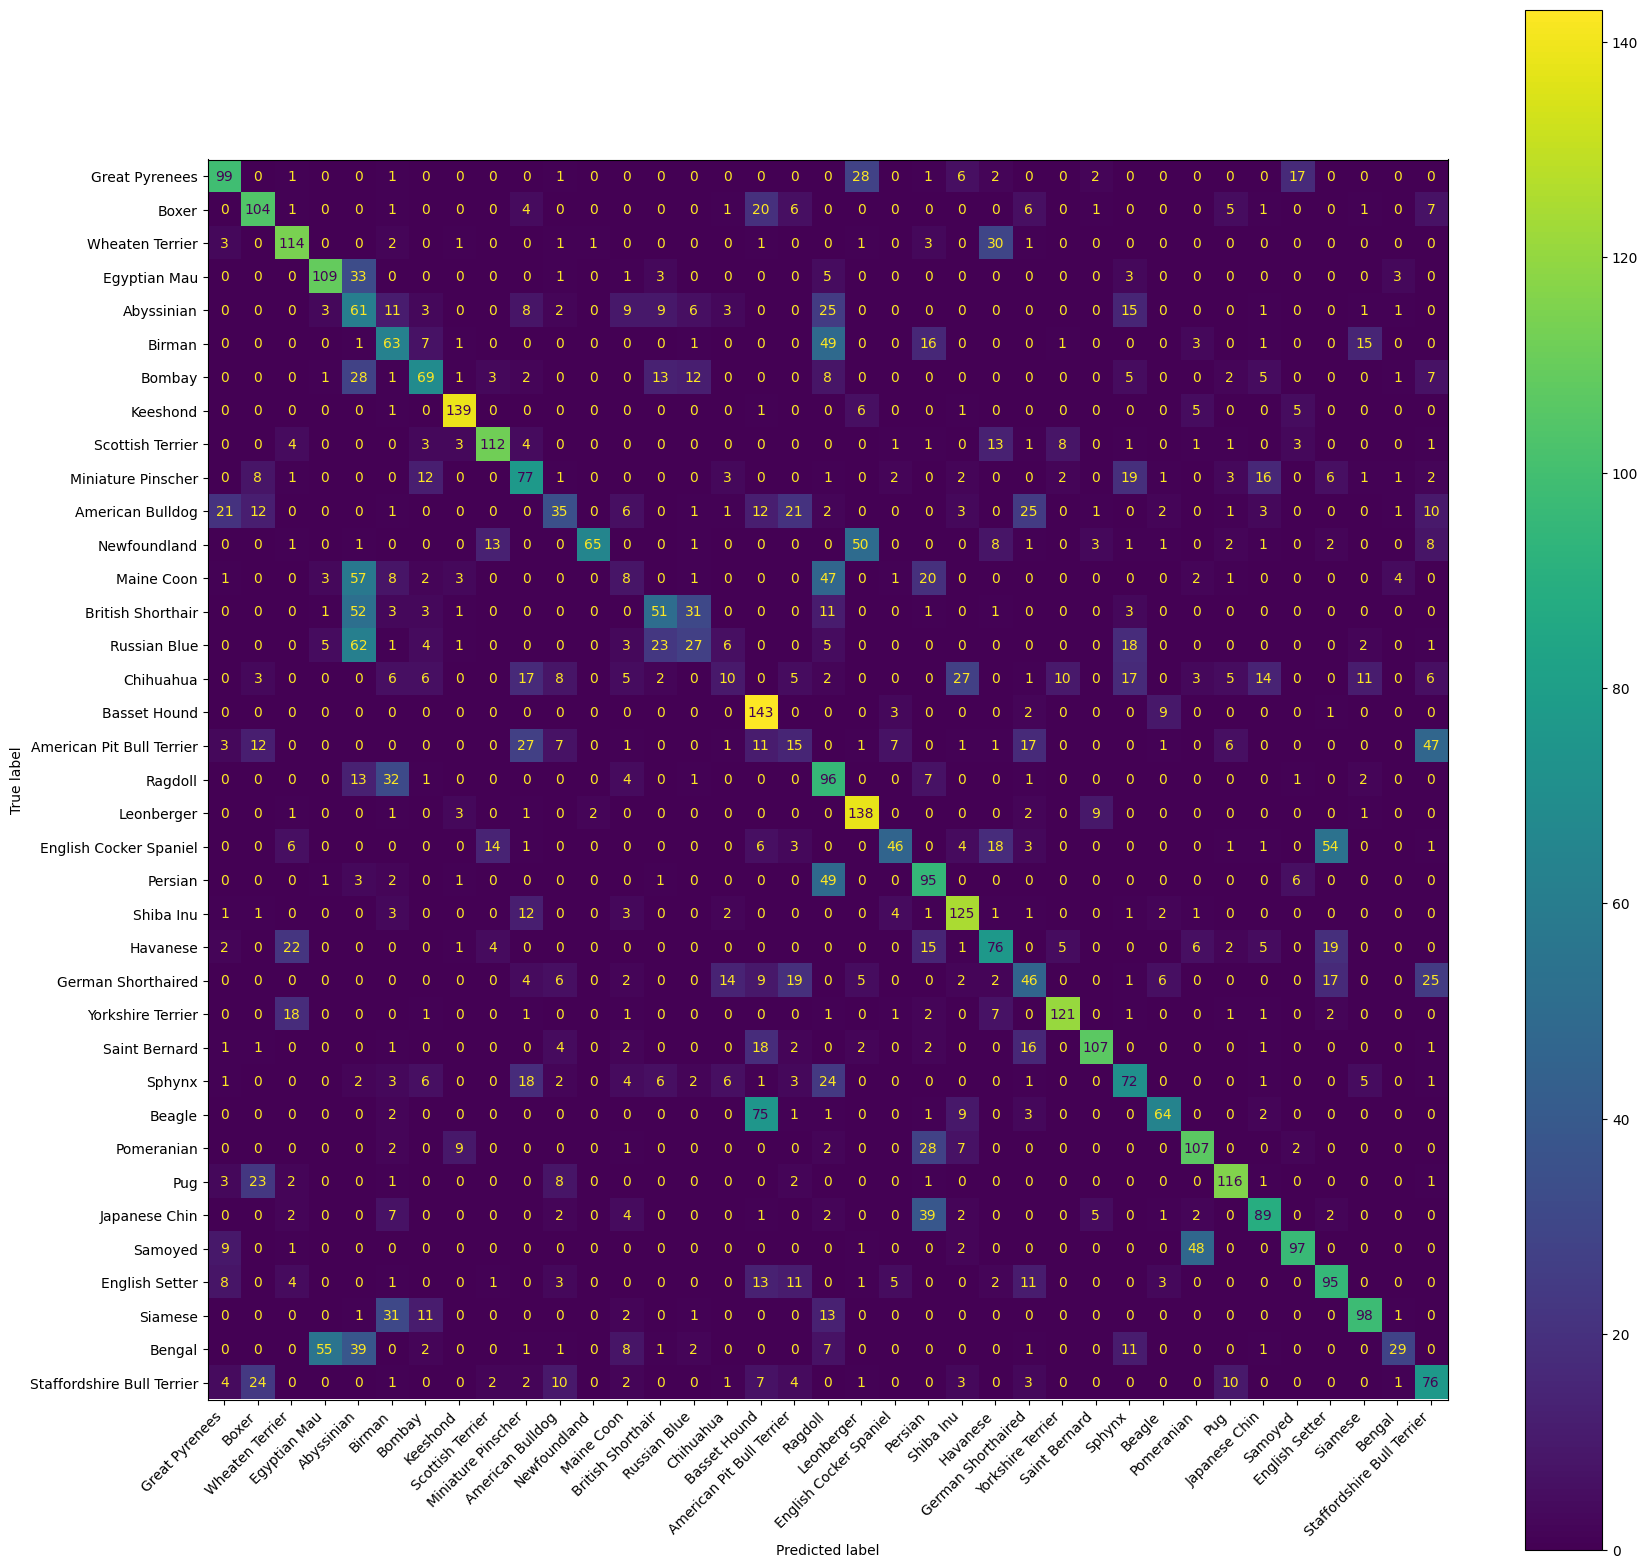

[1,  2001] loss: 0.016
[1,  4001] loss: 0.009
[2,  2001] loss: 0.005
[2,  4001] loss: 0.005
[3,  2001] loss: 0.004
[3,  4001] loss: 0.004
[4,  2001] loss: 0.003
[4,  4001] loss: 0.003
[5,  2001] loss: 0.003
[5,  4001] loss: 0.003
[6,  2001] loss: 0.003
[6,  4001] loss: 0.003
[7,  2001] loss: 0.003
[7,  4001] loss: 0.003
[8,  2001] loss: 0.003
[8,  4001] loss: 0.003
[9,  2001] loss: 0.002
[9,  4001] loss: 0.002
[10,  2001] loss: 0.002
[10,  4001] loss: 0.002
Finished Training
Accuracy on test data: 0.8659444820582262


In [21]:
main(unlabeled_percentage=0.99, extra_layers=[None], epochs=10)

## Two extra layers

In [ ]:
main(unlabeled_percentage=0.5, extra_layers=[None, None], epochs=10)

In [ ]:
main(unlabeled_percentage=0.9, extra_layers=[None, None], epochs=10)

In [ ]:
main(unlabeled_percentage=0.99, extra_layers=[None, None], epochs=10)